In [2]:
# Imports clustering models
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import hdbscan

# Imports data processing and visualization libraries
from sklearn.datasets import make_moons
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Imports standards
from sklearn.metrics import classification_report
from scipy.stats import mode
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Objective

The objective of this notebook is to justify the use of the **HDBSCAN algorithm** within our topic modeling pipeline, and to explain why it outperforms traditional clustering methods in the context of high-dimensional and noisy textual embeddings.

To do so, we use the well-known **Two Moons** synthetic dataset as an illustrative example. This dataset allows us to simulate complex, non-convex structures in a controlled setting. We will apply and compare several clustering algorithms — namely **KMeans**, **Agglomerative Clustering**, and **HDBSCAN** — and analyze their performance through both **visual inspection** and **quantitative metrics** such as the **classification report**.


## Dataset: Two Moons

To support our analysis, we use the **Two Moons** dataset provided by `sklearn.datasets.make_moons`.

This dataset is widely recognized as a **benchmark for testing non-linear clustering algorithms**. It consists of two interleaving half-circles ("moons") that are not linearly separable. As such, it provides a minimal but insightful case for evaluating whether a clustering algorithm can go beyond simple convex boundaries (such as those imposed by KMeans).

In our configuration, we generate:

- `n_samples = 8000` data points,
- with Gaussian noise: `noise = 0.2`,
- and a fixed seed: `random_state = 42` for reproducibility.

### What does the noise parameter do?

The `noise` parameter introduces Gaussian-distributed perturbations to each point’s \( x \) and \( y \) coordinates. Mathematically, for each point \( (x_i, y_i) \), noise is applied as:

$$
\tilde{x}_i = x_i + \epsilon_x \\
\tilde{y}_i = y_i + \epsilon_y \quad \text{with } \epsilon_x, \epsilon_y \sim \mathcal{N}(0, \sigma^2), \quad \sigma = \texttt{noise}
$$

This simulates the kind of ambiguity and imprecision found in real-world high-dimensional data such as sentence embeddings. With `noise = 0.15`, the two moons become fuzzy and partially overlapping — which makes the task significantly more difficult for algorithms based on Euclidean separation or convexity.


## Purpose of using Two Moons

The Two Moons dataset was chosen because it allows us to:
- **Visually and mathematically challenge clustering algorithms** with non-linearly separable structures,
- **Benchmark how each algorithm handles ambiguity and cluster boundary complexity**, under controlled noise,
- Demonstrate that **HDBSCAN**, with its ability to detect **arbitrary-shaped clusters** and **handle noise robustly**, is naturally better suited for tasks like topic modeling, where the underlying cluster shapes are often non-convex, noisy, and overlapping in semantic space.


# Data importation and exploration

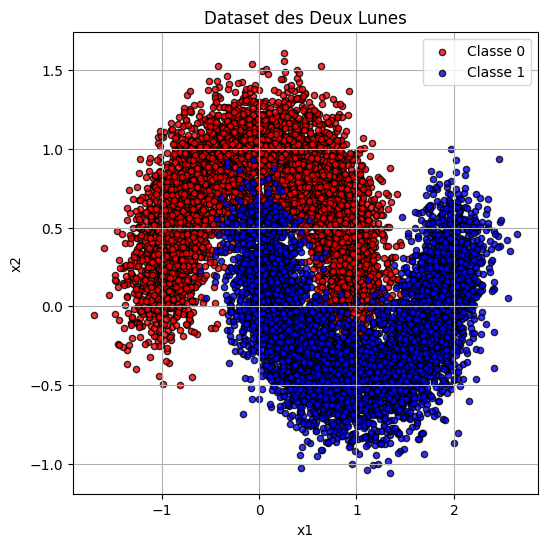

In [3]:
# Générer les données
X, y = make_moons(n_samples=10000, noise=0.2, random_state=42)
df_moons = pd.DataFrame({"x1" : X[:, 0],
                "x2" : X[:, 1],
                "label" : y})
# Visualisation avec légende
plt.figure(figsize=(6, 6))

# Affichage avec deux classes séparées
for label_val, color, label_name in zip([0, 1], ['red', 'blue'], ['Classe 0', 'Classe 1']):
    subset = df_moons[df_moons["label"] == label_val]
    plt.scatter(subset["x1"], subset["x2"], color=color, edgecolors='k', label=label_name, alpha=0.8, s=20)

plt.title("Dataset des Deux Lunes")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
display(df_moons.describe())
# Compter le nombre d'échantillons par classe
print(df_moons['label'].value_counts())

,x1,x2,label
count,10000.000000,10000.000000,10000.000000
mean,0.502298,0.248917,0.500000
std,0.887924,0.530962,0.500025
min,-1.693330,-1.056763,0.000000
25%,-0.122203,-0.186008,0.000000
50%,0.508988,0.242341,0.500000
75%,1.119821,0.683142,1.000000
max,2.644842,1.610324,1.000000


label
1    5000
0    5000
Name: count, dtype: int64


**General Overview**  
The mean values of features **x1** and **x2** are approximately **0.5** and **0.25** respectively, which corresponds to the center of the overall point cloud. The standard deviation indicates that the data are more spread out along the **x1** axis than along **x2**.

**Class Balance**  
The dataset is perfectly balanced, with **5,000 samples** in each class.

**Non‑Linear Structure**  
The most striking characteristic of this dataset is its **non‑linear shape**. As shown in the scatter plot, no single straight line can cleanly separate the red points from the blue ones.

**Impact of Noise**  
An additional challenge is introduced by the parameter **`noise=0.2`**, deliberately set high to test HDBSCAN’s robustness. This noise blurs the boundaries—some points from the blue moon appear in the red moon region and vice versa—making the clustering task more realistic and more difficult.


# Clustering
## K-means

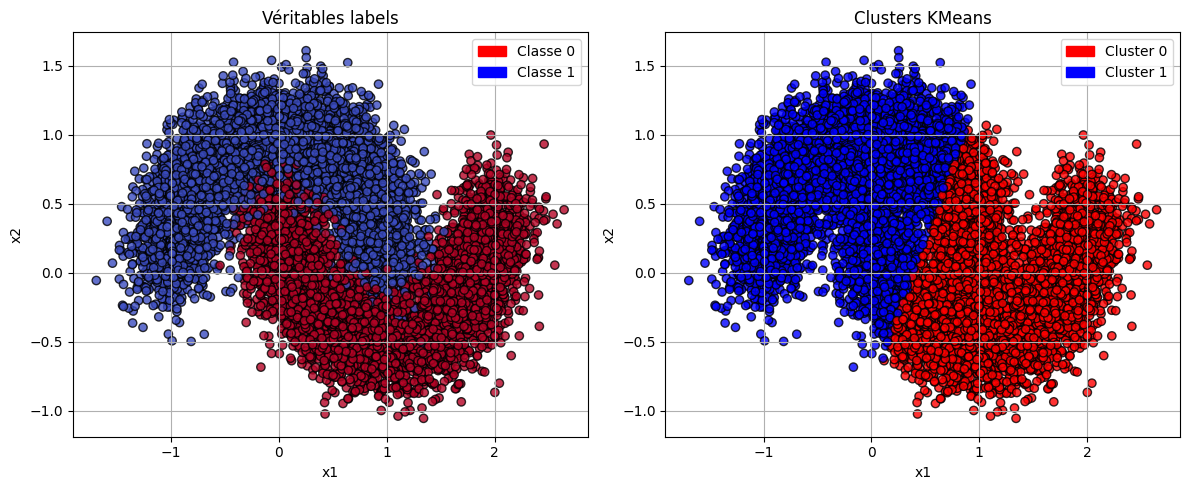

In [5]:
# Application de KMeans avec 2 clusters
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans_labels = kmeans.fit_predict(X)

# Ajout des labels prédits au DataFrame
df_moons["kmeans_label"] = np.abs(kmeans_labels -1) # inverser les labels afin de les aligner avec les vraies classes


cmap_br = ListedColormap(['blue', 'red'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# --- Sous-plot 1 : Vrais labels ---
scatter0 = axes[0].scatter(df_moons["x1"], df_moons["x2"],
                           c=df_moons["label"], cmap='coolwarm',
                           edgecolors='k', alpha=0.8)
axes[0].set_title("Véritables labels")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].grid(True)

# Ajouter légende manuelle pour les vraies classes
legend_labels_true = [mpatches.Patch(color='red', label='Classe 0'),
                      mpatches.Patch(color='blue', label='Classe 1')]
axes[0].legend(handles=legend_labels_true)

# --- Sous-plot 2 : KMeans ---
scatter1 = axes[1].scatter(
    df_moons["x1"], df_moons["x2"],
    c=df_moons["kmeans_label"],
    cmap=cmap_br,
    edgecolors='k', alpha=0.8
)
axes[1].set_title("Clusters KMeans")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].grid(True)

# manual legend matching our colors
legend_labels_kmeans = [
    mpatches.Patch(color='red', label='Cluster 0'),
    mpatches.Patch(color='blue',  label='Cluster 1')
]
axes[1].legend(handles=legend_labels_kmeans)

plt.tight_layout()
plt.show()

In [6]:
# Trouver le mapping optimal
labels_aligned = np.zeros_like(kmeans_labels)
for cluster in np.unique(kmeans_labels):
    mask = kmeans_labels == cluster
    majority_label = mode(y[mask], keepdims=True)[0][0]
    labels_aligned[mask] = majority_label

# Générer le rapport
report = classification_report(y, labels_aligned, target_names=["Classe 0", "Classe 1"])
print(report)

              precision    recall  f1-score   support

    Classe 0       0.75      0.76      0.75      5000
    Classe 1       0.75      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



**Remarks**

- The model is limited: according to the scatter plots and the classification report (precision, recall and f1‑score all weak), KMeans cannot properly separate the two non‑linear “moons.”  
- KMeans works by placing **centroids** and assigning each point to the nearest one, effectively carving space into **straight‑line (Voronoi) regions** suited to **round, convex clusters**.  
- Because the “two moons” are **crescent‑shaped** and **interleaved**, no pair of circular or linear boundaries can separate them cleanly. Under noise, KMeans’ spherical assumption causes systematic mis‑assignments along the curved edges.

## Agglomerative Clustering

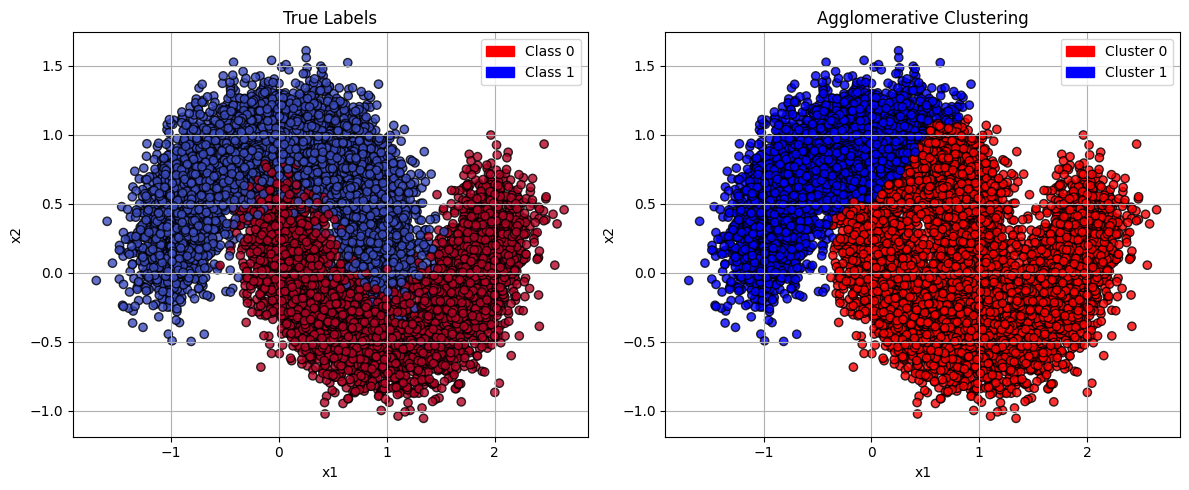

In [7]:
# 1. Fit hierarchical clustering
agglo = AgglomerativeClustering(n_clusters=2, linkage='average')
df_moons["agglo_label"] = agglo.fit_predict(X)

# 2. Plot with Cluster 0 in red, Cluster 1 in blue
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- True labels ---
axes[0].scatter(
    df_moons["x1"], df_moons["x2"],
    c=df_moons["label"], cmap='coolwarm',
    edgecolors='k', alpha=0.8
)
axes[0].set_title("True Labels")
axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2"); axes[0].grid()
axes[0].legend(handles=[
    mpatches.Patch(color='red', label='Class 0'),
    mpatches.Patch(color='blue', label='Class 1')
])

# --- Agglomerative clusters ---
scatter1 = axes[1].scatter(
    df_moons["x1"], df_moons["x2"],
    c=df_moons["agglo_label"],
    cmap=cmap_br.reversed(),
    edgecolors='k', alpha=0.8
)
axes[1].set_title("Agglomerative Clustering")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].grid(True)

# manual legend matching our colors
legend_labels_Agglomerative = [
    mpatches.Patch(color='red', label='Cluster 0'),
    mpatches.Patch(color='blue',  label='Cluster 1')
]
axes[1].legend(handles=legend_labels_Agglomerative)

plt.tight_layout()
plt.show()



In [8]:
y_true = df_moons["label"].to_numpy()
y_pred = df_moons["agglo_label"].to_numpy()

# Réalignement des labels prédits
labels_aligned = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = y_pred == cluster
    majority_label = mode(y_true[mask], keepdims=True)[0][0]
    labels_aligned[mask] = majority_label

print("Rapport de classification – Clustering Hiérarchique Agglomératif")
print(classification_report(y_true, labels_aligned, target_names=["Classe 1", "Classe 0"]))


Rapport de classification – Clustering Hiérarchique Agglomératif
              precision    recall  f1-score   support

    Classe 1       0.97      0.63      0.77      5000
    Classe 0       0.73      0.98      0.84      5000

    accuracy                           0.81     10000
   macro avg       0.85      0.81      0.80     10000
weighted avg       0.85      0.81      0.80     10000



**Remarks**

- The hierarchical model improves overall accuracy to **0.81**, but the **precision/recall trade‑off** is heavily skewed:  
  - **Class 1**: high precision (0.97) but low recall (0.63) → many true Class 1 points are mis‑assigned.  
  - **Class 0**: lower precision (0.73) but very high recall (0.98) → almost all Class 0 points are captured, at the cost of including some Class 1.

- Agglomerative Clustering with **average linkage** merges clusters by minimizing the **average pairwise distance**, which still implicitly favors more **compact shapes** and struggle with **interleaved, crescent‑shaped structures**.

- As a result, one moon becomes “swallowed” by the other in the dendrogram process, producing a **systematic bias** that reduces recall on the interleaved class.  


# HDBSCAN

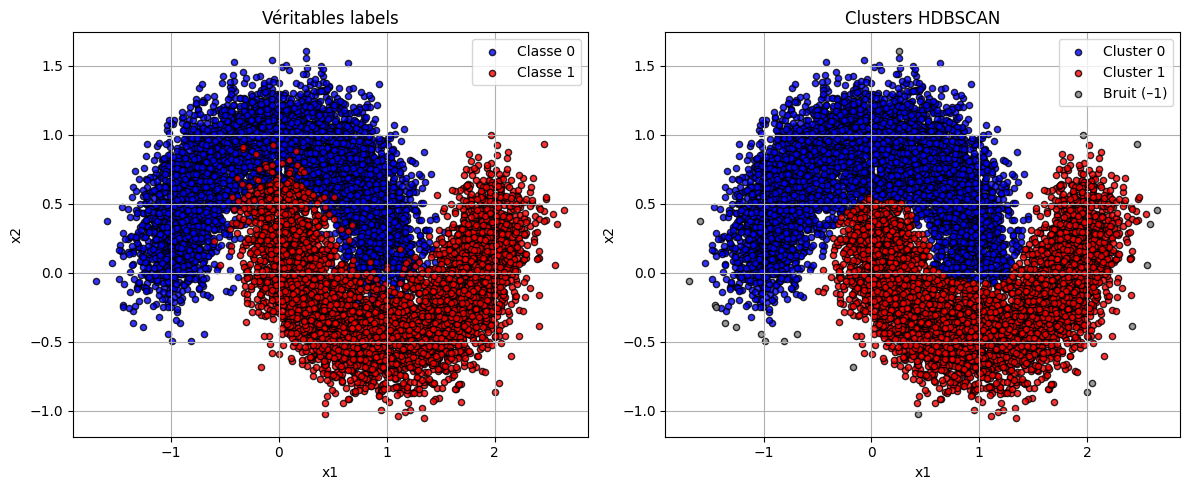

In [9]:
# 1. Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=99)
df_moons["hdbscan_label"] = clusterer.fit_predict(X)

# 2. Plot with swapped colors: true labels (0→blue, 1→red) and HDBSCAN clusters (0→blue, 1→red)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- True labels with swapped colors ---
for lbl, color, name in zip([0, 1], ['blue', 'red'], ['Classe 0', 'Classe 1']):
    subset = df_moons[df_moons["label"] == lbl]
    axes[0].scatter(
        subset["x1"], subset["x2"],
        color=color, edgecolors='k', alpha=0.8, s=20, label=name
    )
axes[0].set_title("Véritables labels")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].grid(True)
axes[0].legend()

# --- HDBSCAN clusters with swapped colors ---
# Cluster 0 → blue, Cluster 1 → red, Noise (–1) → gray
for lbl, color, name in zip([0, 1], ['blue', 'red'], ['Cluster 0', 'Cluster 1']):
    subset = df_moons[df_moons["hdbscan_label"] == lbl]
    axes[1].scatter(
        subset["x1"], subset["x2"],
        color=color, edgecolors='k', alpha=0.8, s=20, label=name
    )
# Plot noise points
noise = df_moons[df_moons["hdbscan_label"] == -1]
axes[1].scatter(
    noise["x1"], noise["x2"],
    color='gray', edgecolors='k', alpha=0.8, s=20, label='Bruit (–1)'
)

axes[1].set_title("Clusters HDBSCAN")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [11]:
y_true = df_moons["label"].to_numpy()
y_pred = df_moons["hdbscan_label"].to_numpy()

# Réalignement des labels prédits
labels_aligned = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = y_pred == cluster
    majority_label = mode(y_true[mask], keepdims=True)[0][0]
    labels_aligned[mask] = majority_label

print("Rapport de classification – Clustering Hiérarchique Agglomératif")
print(classification_report(y_true, labels_aligned, target_names=["Classe 0", "Classe 1"]))


Rapport de classification – Clustering Hiérarchique Agglomératif
              precision    recall  f1-score   support

    Classe 0       0.96      0.97      0.97      5000
    Classe 1       0.97      0.96      0.97      5000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



**Remarks**

- HDBSCAN is the best model: both the scatter plot and the classification report (accuracy = 0.97, precision/recall ≃ 0.97) confirm near‑perfect separation of the two moons.  
- It recovers the **global crescent shapes** while **identifying noise** points (label –1) that do not belong to either moon.  
- Unlike KMeans or Agglomerative Clustering, HDBSCAN’s **density‑based, hierarchical approach** captures arbitrary cluster shapes and robustly excludes outliers, making it ideally suited to our non‑linear, noisy data.  
- However, HDBSCAN is **sensitive to its hyperparameters** (`min_samples`, `min_cluster_size`)—choosing them poorly can lead to excessive noise or fragmented clusters. Careful, data‑driven tuning is therefore essential.
    - **Imagine:** if we leave everything the same but set `min_samples` to **98** instead of **99**, the outlier rate jumps from **0.2 %** to **17.52 %**, and the average F1‑score drops from **0.97** to **0.89**!


# **Conclusion**: HDBSCAN vs Traditional Clustering Algorithms

Numerous studies and expert analyses consistently highlight that **HDBSCAN** outperforms traditional clustering methods such as **DBSCAN**, **OPTICS**, **KMeans**, and **Agglomerative Clustering**, especially in real-world scenarios involving:
- **Arbitrarily shaped clusters**  
- **Varying local densities**  
- **Noisy or high-dimensional data**  

Its key strengths lie in:
- A **hierarchical approach** based on mutual reachability and condensed trees  
- The ability to **automatically infer the number of clusters**  
- Its **resilience to parameter sensitivity**, particularly the absence of the `eps` parameter (a known limitation in DBSCAN)

## Key Supporting Sources

1. **[“Comparing Python Clustering Algorithms” – HDBSCAN Documentation](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)**  
   This official documentation presents a **visual and quantitative comparison** between clustering algorithms (KMeans, DBSCAN, HDBSCAN, etc.) on both synthetic and real datasets. It clearly shows that **HDBSCAN adapts better to complex cluster structures** (e.g., non-convex shapes) and handles noise more effectively. It also includes score-based metrics like the Adjusted Rand Index to quantify clustering performance.

2. **[“Improving the Open Cluster Census: I. Comparison of Clustering Algorithms Applied to Gaia DR2 Data”](https://arxiv.org/abs/2012.04267)**  
   This academic paper applies clustering to **astronomical data from the Gaia satellite**, which includes **irregular spatial distributions** of star clusters. HDBSCAN outperforms other methods (including Gaussian Mixture Models and DBSCAN) by achieving **higher cluster detection rates (82%)** and better alignment with known celestial structures, making it an excellent example of HDBSCAN’s power in scientific data analysis.

3. **[“HDBSCAN: The Supercharged Version of DBSCAN — An Algorithmic Deep Dive”](https://www.dailydoseofds.com/hdbscan-the-supercharged-version-of-dbscan-an-algorithmic-deep-dive/)**  
   This article offers a **deep technical dive** into the HDBSCAN algorithm, its design philosophy, and why it is often a **preferred alternative to DBSCAN**. It emphasizes how HDBSCAN leverages both density-based clustering and hierarchical pruning to deal with **varying density** and **cluster stability**, particularly for datasets where DBSCAN fails due to a global `eps`.



## Final Note

Thanks to these properties, **HDBSCAN stands out as one of the most robust clustering methods** available today. It is particularly effective in use cases like **topic modeling**, **anomaly detection**, and **graph segmentation**, where noise, density variation, and cluster shape are critical challenges.
